In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon

In [4]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load()

In [5]:
ctree.query("灘", use_flag="first")[0].children

[['氵'], [<⿰:[<⿱:廿⿻口夫>]['隹'](GTKV)>]]

In [6]:
yo_hits = ctree.find("又", max_depth=1, bmp_only=True)
yo_hits_simp = [x for x in yo_hits if tsvars.is_simplified(x[0])]
yo_trad_items = []
for hit_x in yo_hits_simp:
    trad_char = tsvars.convert(hit_x[0])[0]
    if hit_x[0] == "鸡":
        trad_char = "鷄"
    try:
        trad_compo = ctree.select(trad_char, hit_x[1], use_flag="shortest")
        yo_trad_items.append((trad_char, hit_x[0], trad_compo))
    except IndexError as ex:
        print(str(ex), trad_char, hit_x[1])
yo_trad_items

IDC does not match 雙 [⿰0双]


[('權', '权', '雚'),
 ('聖', '圣', '𦔻'),
 ('嘆', '叹', '𦰩'),
 ('變', '变', '攵'),
 ('敘', '叙', '攵'),
 ('馭', '驭', '又'),
 ('鄧', '邓', '登'),
 ('難', '难', '𦰩'),
 ('艱', '艰', '𦰩'),
 ('觀', '观', '雚'),
 ('鷄', '鸡', '奚'),
 ('鳳', '凤', '𩾏'),
 ('僅', '仅', '堇'),
 ('歡', '欢', '雚'),
 ('對', '对', <⿱:业𦍌>),
 ('勸', '劝', '雚'),
 ('戲', '戏', '䖒'),
 ('漢', '汉', '𦰩')]

In [7]:
from collections import defaultdict
chars_set = set()
compo_set = set()
decompo_set = set()
for item_x in yo_trad_items:
    trad_char = item_x[0]
    simp_char = item_x[1]
    chars_set.add(trad_char)
    chars_set.add(simp_char)    
    trad_ortho = ctree.query(trad_char, 
                              max_depth=1, 
                              use_flag="shortest")[0]
    simp_ortho = ctree.query(simp_char,
                              max_depth=1,
                              use_flag="shortest")[0]
    for compo_i in [0, 1]:
        if trad_ortho.idc != simp_ortho.idc:
            continue
        trad_compo = trad_ortho.get_component(compo_i)
        simp_compo = simp_ortho.get_component(compo_i)        
        compo_set.add(str(trad_compo))
        compo_set.add(str(simp_compo))
        decompo_set.add((trad_char, str(trad_compo)))        
        decompo_set.add((simp_char, str(simp_compo)))
        if simp_compo == "又" and simp_compo != trad_compo:                                 
            trad_neighs = [x[0] for x in 
                           ctree.find(trad_compo, max_depth=1, 
                                      use_flag="shortest",
                                      bmp_only=True)]
            trad_neighs = [x for x in trad_neighs if x in lexicon]
            neighs = set(trad_neighs).difference([x[0] for x in yo_trad_items])            
            simp_neighs = [tsvars.convert(x)[0] for x in neighs]
            neigh_chars = neighs | set(simp_neighs)
            chars_set |= neigh_chars            
            for neigh_x in neigh_chars:
                ortho_x = ctree.query(neigh_x, max_depth=1, use_flag="shortest")[0]
                compos_x = set(str(ortho_x.get_component(x)) 
                                 for x in range(len(ortho_x.children)))
                compo_set |= compos_x
                decompo_set |= set((neigh_x, x) for x in compos_x)
    

In [8]:
len(chars_set), len(compo_set), len(decompo_set)

(105, 84, 215)

## Component Matrix

In [9]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [10]:
char_enc = LabelEncoder()
compo_enc = LabelEncoder()
char_enc.fit(list(chars_set))
compo_enc.fit(list(compo_set))

LabelEncoder()

In [11]:
n_char = len(char_enc.classes_)
n_compo = len(compo_enc.classes_)

In [12]:
decompo_matrix = np.zeros((n_char, n_compo), dtype=np.int32)
decompo_matrix.shape

(105, 84)

In [13]:
list(decompo_set)[0]

('变', '亦')

In [14]:
for item_x in decompo_set:
    char_idx = char_enc.transform([item_x[0]])[0]
    compo_idx = compo_enc.transform([item_x[1]])[0]
    decompo_matrix[char_idx, compo_idx] = 1

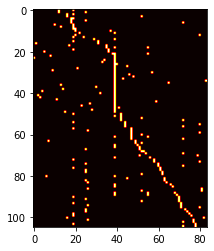

In [15]:
from matplotlib import pyplot as plt
plt.imshow(decompo_matrix, cmap="hot")

In [35]:
from gensim.models.keyedvectors import KeyedVectors

In [36]:
kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [37]:
## Character semantic vector
word_kv_idxs = []
for word in char_enc.classes_:
    word_kv_idxs.append(kv.vocab[word].index)
char_ft = kv.vectors_norm[word_kv_idxs, :]
char_ft.shape

(105, 300)

## Component semantic matrix
$$
C_{k\times d}: \textrm{Component semantic matrix, k components $\times$ d vector size }\\
Z_{n\times d}: \textrm{Character semantic matrix, n characters $\times$ d vector size }\\
D_{n\times k}: \textrm{Decomposition matrix, n characters $\times$ k components}\\
Z = D\cdot C\\
C = (D^\top D)^{-1}D^\top Z
$$

In [38]:
import numpy as np
import numpy.linalg as la

D = decompo_matrix
Z = char_ft
print("D, Z: ", D.shape, Z.shape)
compo_ft = la.inv(D.T.dot(D)).dot(D.T).dot(Z)

D, Z:  (105, 84) (105, 300)


In [39]:
print(compo_enc.classes_)

['⿰亻丨' '⿱业𦍌' '⿱乛耳' '⿱龷⺼' '㡀' '䖒' '䜌' '丁' '丩' '交' '亦' '享' '亻' '余' '佥' '僉'
 '几' '切' '力' '又' '口' '古' '启' '啇' '土' '堇' '奚' '娄' '婁' '子' '孝' '寸' '尚' '工'
 '己' '彳' '戈' '户' '扌' '攵' '方' '旉' '木' '束' '欠' '正' '每' '氵' '求' '火' '牛' '王'
 '登' '目' '缶' '育' '至' '舌' '艮' '苟' '見' '见' '言' '讠' '谷' '貝' '贝' '赤' '車' '车'
 '阝' '隹' '雚' '飠' '饣' '馬' '马' '鳥' '鸟' '𦔻' '𦰩' '𧾷' '𩾏' '𫠤']


In [44]:
compo_vec = compo_ft[compo_enc.transform(["阝"])[0]]
kv.similar_by_vector(compo_vec)

[('证', 0.9045802354812622),
 ('鄞', 0.903767466545105),
 ('鄧', 0.8978380560874939),
 ('邓', 0.8958058953285217),
 ('鄒', 0.8950450420379639),
 ('邵', 0.8906866908073425),
 ('凤', 0.8874679803848267),
 ('槎', 0.8872071504592896),
 ('枚', 0.8870352506637573),
 ('裘', 0.8868542909622192)]

In [41]:
import re
re.match("^[一-龜]$", "中二")

In [42]:
kv.vocab

{'的': <gensim.models.keyedvectors.Vocab at 0x22ffadd78e0>,
 '年': <gensim.models.keyedvectors.Vocab at 0x22ffadd7d30>,
 '月': <gensim.models.keyedvectors.Vocab at 0x22ffadd79d0>,
 '日': <gensim.models.keyedvectors.Vocab at 0x22ffadd7ac0>,
 '在': <gensim.models.keyedvectors.Vocab at 0x22ffd626bb0>,
 '是': <gensim.models.keyedvectors.Vocab at 0x22ffd626a60>,
 '和': <gensim.models.keyedvectors.Vocab at 0x22ffd626ee0>,
 '了': <gensim.models.keyedvectors.Vocab at 0x22ffd626520>,
 '村': <gensim.models.keyedvectors.Vocab at 0x22ffd6264f0>,
 '人': <gensim.models.keyedvectors.Vocab at 0x22ffd626550>,
 '中': <gensim.models.keyedvectors.Vocab at 0x22ffd626340>,
 '为': <gensim.models.keyedvectors.Vocab at 0x22ffd626490>,
 '為': <gensim.models.keyedvectors.Vocab at 0x22ffd626d90>,
 '被': <gensim.models.keyedvectors.Vocab at 0x22ffd6261f0>,
 '斯': <gensim.models.keyedvectors.Vocab at 0x22ffadb24c0>,
 '有': <gensim.models.keyedvectors.Vocab at 0x22ffadb2460>,
 '及': <gensim.models.keyedvectors.Vocab at 0x22ffadb24f0